In [1]:
# Check GPU status
!nvidia-smi


Thu Sep  5 17:45:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# Install necessary libraries
!pip install torch torchvision torchaudio
!pip install torch-geometric
!pip install tikzplotlib
!pip install grape
!pip install seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.7/323.7 kB 26.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (set

In [3]:
# basics
import numpy as np
import pandas as pd
import tensorflow as tf

# math
from math import ceil
from math import log
from math import log10

# utils
import itertools as it
import time
#from varname import nameof # get the name of a variable
import pickle
from tqdm.auto import tqdm, trange
#from tqdm import tqdm  RuntimeError: CUDA error: device-side assert triggered
import inspect
from grape.datasets.linqs import get_words_data # words information is excluded
from sklearn.preprocessing import LabelEncoder


# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import tikzplotlib
#from barplots import barplots
import matplotlib.colors as colors
import seaborn as sns
from sklearn.manifold import TSNE


# torch geometrics
import torch
import torch.optim as optim

from torch_geometric.datasets import FB15k_237
from torch_geometric.nn import ComplEx, DistMult, RotatE, TransE
from torch_geometric.data import Data

import os.path as osp

# Convolutional GNN
import torch_geometric.transforms as T

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.transforms import RandomLinkSplit

from sklearn.metrics import roc_auc_score
# # Grape

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
# # Grape
# from grape.datasets import get_all_available_graphs_dataframe
# from grape.datasets import get_dataset
from grape import Graph
from grape import GraphVisualizer

# # Ensmallen
# from grape.embedders import Node2VecCBOWEnsmallen, Node2VecGloVeEnsmallen, Node2VecSkipGramEnsmallen
# from grape.embedders import DeepWalkCBOWEnsmallen, DeepWalkGloVeEnsmallen, DeepWalkSkipGramEnsmallen
# from grape.embedders import WalkletsSkipGramEnsmallen, WalkletsCBOWEnsmallen, WalkletsGloVeEnsmallen
# from grape.embedders import FirstOrderLINEEnsmallen, SecondOrderLINEEnsmallen
# #from grape.embedders import NetMFEnsmallen, GLEEEnsmallen, HOPEEnsmallen
from grape.embedders import TransEEnsmallen

# # TensorFlow
# from grape.embedders import SkipGramTensorFlow, CBOWTensorFlow
# from grape.embedders import FirstOrderLINETensorFlow, SecondOrderLINETensorFlow

# # KarateClub
# from grape.embedders import Role2VecKarateClub, GraRepKarateClub
# from grape.embedders import NMFADMMKarateClub, RandNEKarateClub


# # Edge prediction evaluation
from grape.edge_prediction import edge_prediction_evaluation
from grape.edge_prediction import DecisionTreeEdgePrediction, RandomForestEdgePrediction, ExtraTreesEdgePrediction, MLPEdgePrediction, GradientBoostingEdgePrediction,PerceptronEdgePrediction

# from grape.edge_prediction import KipfGCNEdgePrediction

# # Node Label prediction evaluation
# from grape.node_label_prediction import node_label_prediction_evaluation
# from grape.node_label_prediction import DecisionTreeNodeLabelPrediction, RandomForestNodeLabelPrediction, MLPNodeLabelPrediction, GradientBoostingNodeLabelPrediction#, PerceptronNodeLabelPrediction

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
# Load graph
view=1
view_name='VIEW'+str(view)
results = pd.DataFrame()

# Load graph
view_path='/content/drive/MyDrive/VIEW'+str(view)+"/"

nodes_df = pd.read_pickle(view_path+"nodes.pkl")
edges_df = pd.read_pickle(view_path+"edges.pkl")

In [8]:
# TRAIN DATASET

nodes_df.to_csv(view_path+"nodes.csv", header=False, index=False, sep='\t')
edges_df.to_csv(view_path+"edges.csv", header=False, index=False, sep='\t')

In [9]:
# IMPORT METHODS

# One-hot encoding of the types
class TypeOneHotEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), len(mapping))
        for i, col in enumerate(df.values):
            for type in col.split(self.sep):
                x[i, mapping[type]] = 1
        return x

# Integer encoding for types
class TypeIntegerEncoder:
    def __init__(self, sep='|'):
        self.sep = sep

    def __call__(self, df):
        types = set(g for col in df.values for g in col.split(self.sep))
        mapping = {type: i for i, type in enumerate(types)}

        x = torch.zeros(len(df), 1)
        for i, type in enumerate(df.values):
                x[i] = mapping[type]
        return x.to(torch.float)

In [10]:
def load_node_df(df, index_col, encoders=None, **kwargs):

    # Integer encoding for the types
    type_mapping: Dict[str, int] = {}

    df = df.set_index(index_col)
    # Create te mapping for the index
    mapping = {index: i for i, index in enumerate(df.index.unique())}

    # Create the features for the nodes
    x = None
    if encoders is not None:
        xs = [encoder(df[col]) for col, encoder in encoders.items()]
        x = torch.cat(xs, dim=-1)

    return x, mapping

def load_edge_df(df, src_index_col, src_mapping, dst_index_col, dst_mapping,
                 pred_index_col=None, pred_mapping=None, encoders=None, **kwargs):

    src = [src_mapping[index] for index in df[src_index_col]]
    dst = [dst_mapping[index] for index in df[dst_index_col]]
    edge_index = torch.tensor([src, dst])

    # Edge Types
    edge_attr = None
    # Edge mapping
    if pred_mapping is not None:
        edge_attrs = torch.zeros(len(df), 1)
        for i, type in enumerate(df[pred_index_col].values):
            edge_attrs[i] = pred_mapping[type]
        edge_attr = edge_attrs.to(torch.int64)
    # No mapping but encoder
    if encoders is not None:
        edge_attrs = [encoder(df[col]) for col, encoder in encoders.items()]
        edge_attr = torch.cat(edge_attrs, dim=-1)

    return edge_index, edge_attr

In [11]:
# Train

nodes_x, node_mapping = load_node_df(nodes_df, index_col='name',
                                     encoders={'type': TypeIntegerEncoder()}
                                    )

# Edge type mapping (same for train/test)
pred_mapping = {index: i for i, index in enumerate(edges_df.predicate.unique())}

edge_index, edge_type = load_edge_df(
    edges_df,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

# train_data = Data(x=nodes_x,
#                   edge_index=edge_index, edge_type=edge_type,
#                   edge_label_index=edge_index,
#                   edge_label=torch.ones(edge_index.size(1))
#                     )

# train_data = train_data.to(device)

In [12]:
data = Data(x=nodes_x, edge_index=edge_index, edge_type=edge_type)

transform = RandomLinkSplit(is_undirected=False)

train_data, val_data, test_data = transform(data)

train_data = train_data.to(device)
test_data = test_data.to(device)
val_data = val_data.to(device)

In [13]:
print(f"Edges Train: {len(train_data.edge_label_index[0])}  Test:{len(test_data.edge_label_index[0])}  Validation: {len(val_data.edge_label_index[0])}")

Edges Train: 2365462  Test:675846  Validation: 337922


In [14]:
# Model

model = ComplEx(
    num_nodes=train_data.num_nodes,
    num_relations=train_data.num_edge_types,
    hidden_channels=50, # The hidden embedding size.
).to(device)

loader = model.loader(
    head_index=train_data.edge_index[0],
    rel_type=train_data.edge_type,
    tail_index=train_data.edge_index[1],
    batch_size=1000,
    shuffle=True,
)

optimizer = optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6)

# ALTERNATIVE MODELS

# model_map = {
#     'transe': TransE,
#     'complex': ComplEx,
#     'distmult': DistMult,
#     'rotate': RotatE,
# }

# Proposed configurations
# optimizer_map = {
#     'transe': optim.Adam(model.parameters(), lr=0.01),
#     'complex': optim.Adagrad(model.parameters(), lr=0.001, weight_decay=1e-6),
#     'distmult': optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-6),
#     'rotate': optim.Adam(model.parameters(), lr=1e-3),
# }

In [15]:
# Training definitions

def train():
    model.train()
    total_loss = total_examples = 0
    for head_index, rel_type, tail_index in loader:
        optimizer.zero_grad()
        loss = model.loss(head_index, rel_type, tail_index)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * head_index.numel()
        total_examples += head_index.numel()
    return total_loss / total_examples


@torch.no_grad()
def test(data):
    model.eval()
    return model.test(
        head_index=data.edge_index[0],
        rel_type=data.edge_type,
        tail_index=data.edge_index[1],
        batch_size=20000,
        k=10,
    )

@torch.no_grad()
def get_prob(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return out.cpu().numpy()

In [ ]:
# Training
n_epochs=52

for epoch in range(1, n_epochs):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, '
        f'Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

Epoch: 001, Loss: 0.6927
Epoch: 002, Loss: 0.6886
Epoch: 003, Loss: 0.6811
Epoch: 004, Loss: 0.6719
Epoch: 005, Loss: 0.6616
Epoch: 006, Loss: 0.6506
Epoch: 007, Loss: 0.6395
Epoch: 008, Loss: 0.6284
Epoch: 009, Loss: 0.6175
Epoch: 010, Loss: 0.6070
Epoch: 011, Loss: 0.5969
Epoch: 012, Loss: 0.5872
Epoch: 013, Loss: 0.5782
Epoch: 014, Loss: 0.5696
Epoch: 015, Loss: 0.5616
Epoch: 016, Loss: 0.5540
Epoch: 017, Loss: 0.5471
Epoch: 018, Loss: 0.5403
Epoch: 019, Loss: 0.5342
Epoch: 020, Loss: 0.5284
Epoch: 021, Loss: 0.5230
Epoch: 022, Loss: 0.5182
Epoch: 023, Loss: 0.5134
Epoch: 024, Loss: 0.5089
Epoch: 025, Loss: 0.5048


100%|██████████| 1182731/1182731 [1:10:18<00:00, 280.39it/s]


Epoch: 025, Val Mean Rank: 5792.55, Val MRR: 0.0243, Val Hits@10: 0.0381
Epoch: 026, Loss: 0.5009
Epoch: 027, Loss: 0.4969
Epoch: 028, Loss: 0.4932
Epoch: 029, Loss: 0.4902
Epoch: 030, Loss: 0.4868
Epoch: 031, Loss: 0.4841
Epoch: 032, Loss: 0.4810
Epoch: 033, Loss: 0.4784
Epoch: 034, Loss: 0.4757
Epoch: 035, Loss: 0.4729
Epoch: 036, Loss: 0.4711
Epoch: 037, Loss: 0.4687
Epoch: 038, Loss: 0.4663
Epoch: 039, Loss: 0.4644
Epoch: 040, Loss: 0.4620
Epoch: 041, Loss: 0.4604
Epoch: 042, Loss: 0.4582
Epoch: 043, Loss: 0.4562
Epoch: 044, Loss: 0.4544
Epoch: 045, Loss: 0.4530
Epoch: 046, Loss: 0.4509
Epoch: 047, Loss: 0.4490
Epoch: 048, Loss: 0.4479
Epoch: 049, Loss: 0.4460
Epoch: 050, Loss: 0.4449


100%|██████████| 1182731/1182731 [1:10:15<00:00, 280.55it/s]


Epoch: 050, Val Mean Rank: 5628.00, Val MRR: 0.0242, Val Hits@10: 0.0380
Epoch: 051, Loss: 0.4431


In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0001):
        self.patience = patience
        self.min_delta = min_delta
        self.best_mrr = float('-inf')
        self.epochs_without_improvement = 0

    def should_stop(self, current_mrr):
        if current_mrr > self.best_mrr + self.min_delta:
            self.best_mrr = current_mrr
            self.epochs_without_improvement = 0
        else:
            self.epochs_without_improvement += 1

        if self.epochs_without_improvement >= self.patience:
            return True
        return False

early_stopping = EarlyStopping(patience=10, min_delta=0.0001)

n_epochs = 75
for epoch in range(1, n_epochs + 1):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

    if epoch % 25 == 0:
        rank, mrr, hits = test(val_data)
        print(f'Epoch: {epoch:03d}, Val Mean Rank: {rank:.2f}, Val MRR: {mrr:.4f}, Val Hits@10: {hits:.4f}')

        if early_stopping.should_stop(mrr):
            print(f'Early stopping triggered after {epoch} epochs.')
            break

# Final evaluation on the test set
test_rank, test_mrr, test_hits = test(test_data)
print(f'Test Mean Rank: {test_rank:.2f}, Test MRR: {test_mrr:.4f}, Test Hits@10: {test_hits:.4f}')


Epoch: 001, Loss: 0.4415
Epoch: 002, Loss: 0.4402
Epoch: 003, Loss: 0.4392
Epoch: 004, Loss: 0.4378
Epoch: 005, Loss: 0.4364
Epoch: 006, Loss: 0.4351
Epoch: 007, Loss: 0.4339
Epoch: 008, Loss: 0.4321
Epoch: 009, Loss: 0.4314
Epoch: 010, Loss: 0.4302
Epoch: 011, Loss: 0.4287
Epoch: 012, Loss: 0.4282
Epoch: 013, Loss: 0.4261
Epoch: 014, Loss: 0.4252
Epoch: 015, Loss: 0.4239
Epoch: 016, Loss: 0.4229
Epoch: 017, Loss: 0.4223
Epoch: 018, Loss: 0.4210
Epoch: 019, Loss: 0.4197
Epoch: 020, Loss: 0.4187
Epoch: 021, Loss: 0.4177
Epoch: 022, Loss: 0.4170
Epoch: 023, Loss: 0.4160
Epoch: 024, Loss: 0.4146
Epoch: 025, Loss: 0.4137


100%|██████████| 1182731/1182731 [1:10:23<00:00, 280.05it/s]


Epoch: 025, Val Mean Rank: 5550.52, Val MRR: 0.0240, Val Hits@10: 0.0378
Epoch: 026, Loss: 0.4129
Epoch: 027, Loss: 0.4120
Epoch: 028, Loss: 0.4110
Epoch: 029, Loss: 0.4101
Epoch: 030, Loss: 0.4095
Epoch: 031, Loss: 0.4084
Epoch: 032, Loss: 0.4073
Epoch: 033, Loss: 0.4065
Epoch: 034, Loss: 0.4056
Epoch: 035, Loss: 0.4049
Epoch: 036, Loss: 0.4039
Epoch: 037, Loss: 0.4030
Epoch: 038, Loss: 0.4019
Epoch: 039, Loss: 0.4015
Epoch: 040, Loss: 0.4009
Epoch: 041, Loss: 0.3998
Epoch: 042, Loss: 0.3991
Epoch: 043, Loss: 0.3982
Epoch: 044, Loss: 0.3976
Epoch: 045, Loss: 0.3962
Epoch: 046, Loss: 0.3963
Epoch: 047, Loss: 0.3953
Epoch: 048, Loss: 0.3943
Epoch: 049, Loss: 0.3938
Epoch: 050, Loss: 0.3929


100%|██████████| 1182731/1182731 [1:10:23<00:00, 280.07it/s]


Epoch: 050, Val Mean Rank: 5509.10, Val MRR: 0.0237, Val Hits@10: 0.0374
Epoch: 051, Loss: 0.3926
Epoch: 052, Loss: 0.3912
Epoch: 053, Loss: 0.3899
Epoch: 054, Loss: 0.3897
Epoch: 055, Loss: 0.3894
Epoch: 056, Loss: 0.3887
Epoch: 057, Loss: 0.3878
Epoch: 058, Loss: 0.3866
Epoch: 059, Loss: 0.3863
Epoch: 060, Loss: 0.3856
Epoch: 061, Loss: 0.3848
Epoch: 062, Loss: 0.3844
Epoch: 063, Loss: 0.3834
Epoch: 064, Loss: 0.3829
Epoch: 065, Loss: 0.3824
Epoch: 066, Loss: 0.3820
Epoch: 067, Loss: 0.3814
Epoch: 068, Loss: 0.3806
Epoch: 069, Loss: 0.3796
Epoch: 070, Loss: 0.3787
Epoch: 071, Loss: 0.3786
Epoch: 072, Loss: 0.3779
Epoch: 073, Loss: 0.3772
Epoch: 074, Loss: 0.3770
Epoch: 075, Loss: 0.3762


100%|██████████| 1182731/1182731 [1:10:20<00:00, 280.23it/s]


Epoch: 075, Val Mean Rank: 5479.09, Val MRR: 0.0234, Val Hits@10: 0.0366


100%|██████████| 1351692/1351692 [1:20:22<00:00, 280.27it/s]


Test Mean Rank: 5558.90, Test MRR: 0.0233, Test Hits@10: 0.0365


In [ ]:
## EXTERNAL TEST SETS

## VIEW 0-2
test_sets = ['miRNA-disease2bepred']
test_df = pd.read_csv(view_path+test_sets[0]+".txt", sep='\t')

## VIEW 3-5
#test_df = pd.read_csv(view_path+"miRNA-disease2bepred.txt", sep='\t')
#test_sets = ['miRNA-disease2bepred']
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 6-8
#test_df = pd.read_csv(view_path+"miRNA-gene2bepred.txt", sep='\t')
#test_sets = ['SPIRES_FN','SPIRES_FP','SPIRES_TP']

## VIEW 12-15 NO HEADERS!!
#test_df = pd.read_csv(view_path+"test-.txt",names=["subject","predicate","object"], sep='\t')

In [ ]:
# Remove edges with unknown nodes
sources_in_graph = test_df.subject.apply(lambda x: x in nodes_df.name.values)
destinations_in_graph = test_df.object.apply(lambda x: x in nodes_df.name.values)

edge_extremes_in_graph = [a and b for a, b in zip(sources_in_graph, destinations_in_graph)]

print([[x,edge_extremes_in_graph.count(x)] for x in set(edge_extremes_in_graph)])

edges_to_predict_filtered = test_df[edge_extremes_in_graph]

test_edge_index, test_edge_type = load_edge_df(
    edges_to_predict_filtered,
    src_index_col='subject', src_mapping = node_mapping,
    dst_index_col='object', dst_mapping = node_mapping,
    pred_index_col='predicate', pred_mapping = pred_mapping,
     # encoders={
     #     'predicate': TypeIntegerEncoder()
     #     }
    )

external_test_data = Data(x=nodes_x,
                 edge_index=test_edge_index,
                 edge_type=test_edge_type,
                 edge_label_index=test_edge_index,
                 edge_label=torch.ones(test_edge_index.size(1))
                ).to(device)

[[False, 12], [True, 16900]]


In [ ]:
rank, mrr, hits_at_10 = test(external_test_data)
print(f'Test Mean Rank: {rank:.2f}, Test MRR: {mrr:.4f}, '
 f'Test Hits@10: {hits_at_10:.4f}')

100%|██████████| 16900/16900 [00:59<00:00, 285.23it/s]

Test Mean Rank: 14979.26, Test MRR: 0.0431, Test Hits@10: 0.1721


In [ ]:
node_embedding = pd.DataFrame(model.node_emb.weight.cpu().detach().numpy())

label_encoder = LabelEncoder()
node_types = label_encoder.fit_transform(list(nodes_df.type))
node_embedding.index = nodes_df
len(node_embedding)

85064

In [ ]:
node_embedding

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
"(<http://purl.obolibrary.org/obo/MONDO_0007247>, Disease)",-0.054448,-0.050677,0.019184,0.020749,-0.058918,0.036495,0.064337,-0.056296,-0.056830,-0.017667,...,-0.056970,-0.076905,0.060034,-0.055180,-0.056980,0.024559,-0.026786,-0.075843,0.057129,0.046256
"(<https://www.mirbase.org/mature/MIMAT0015042>, miRNA)",0.064755,0.194154,-0.175712,0.213965,0.194382,-0.193437,-0.198076,0.195617,-0.168087,-0.215311,...,-0.162923,0.177926,-0.195077,0.110958,-0.165455,0.132407,-0.212574,0.170198,0.164814,-0.198369
"(<http://purl.obolibrary.org/obo/UBERON_0002195>, Anatomy)",-0.044030,-0.047023,0.020900,0.018723,-0.058449,0.037255,0.063303,-0.056700,-0.051498,-0.015665,...,-0.051310,-0.074879,0.058987,-0.044202,-0.051245,0.022625,-0.024238,-0.073213,0.051283,0.044061
"(<http://purl.obolibrary.org/obo/MONDO_0004583>, Disease)",-0.047152,-0.052385,0.022888,0.015556,-0.057491,0.039748,0.061941,-0.056159,-0.052909,-0.012227,...,-0.052789,-0.075279,0.058164,-0.047932,-0.052851,0.019197,-0.021720,-0.073411,0.052824,0.049423
"(<http://purl.obolibrary.org/obo/GO_0060761>, GO)",-0.051624,-0.054780,0.022286,0.018195,-0.067010,0.037913,0.071524,-0.063730,-0.055516,-0.014146,...,-0.055710,-0.082140,0.067978,-0.051779,-0.055838,0.027523,-0.025118,-0.080080,0.055643,0.050518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(<http://purl.obolibrary.org/obo/MONDO_0010781>, Disease)",-0.055610,-0.055705,0.027721,0.016370,-0.061619,0.043625,0.066473,-0.060073,-0.054700,-0.011857,...,-0.055484,-0.077349,0.062435,-0.056551,-0.055798,0.012636,-0.023111,-0.075040,0.055566,0.052168
"(<http://purl.obolibrary.org/obo/HP_0100454>, Phenotype)",-0.048908,-0.053407,0.022712,0.016780,-0.059098,0.039829,0.063991,-0.058148,-0.052462,-0.013522,...,-0.052762,-0.074874,0.060358,-0.049702,-0.052824,0.018905,-0.022592,-0.073258,0.052678,0.050097
"(<http://www.ncbi.nlm.nih.gov/gene/57101>, Gene)",0.021554,-0.060088,0.036555,-0.056240,-0.008651,0.023894,0.006898,-0.011139,0.047220,0.057857,...,0.047719,0.035192,0.013427,0.007375,0.047488,-0.034189,0.054327,0.035985,-0.046967,0.062275
"(<http://www.ncbi.nlm.nih.gov/gene/51316>, Gene)",0.060766,-0.070660,0.039933,-0.095319,0.043209,0.019381,-0.053703,0.034406,0.091862,0.096207,...,0.092140,0.084986,-0.044635,0.042477,0.090968,-0.076896,0.095462,0.085600,-0.092190,0.084823


In [ ]:
!ls -lh


total 8.0K
drwx------ 5 root root 4.0K Jul 28 09:16 drive
drwxr-xr-x 1 root root 4.0K Jul 25 13:21 sample_data


In [ ]:
node_embedding.to_csv('node_embeddings.csv', header=False, index=True, sep=',')

In [ ]:
%matplotlib inline

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h)

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

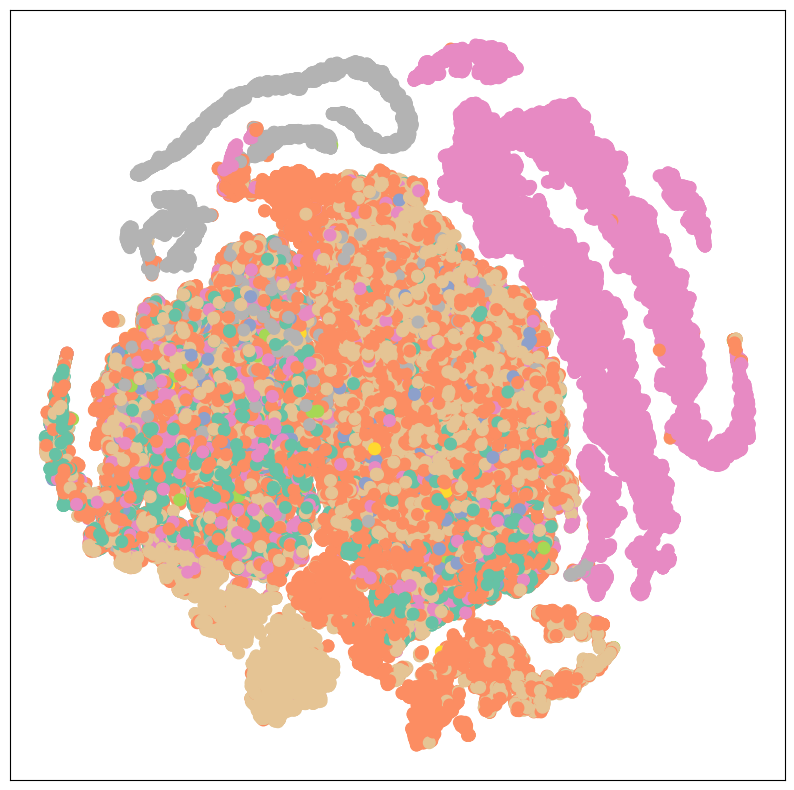

In [ ]:
visualize(node_embedding,node_types)

In [16]:
node_embeddings = pd.read_csv('/content/drive/MyDrive/models_thesis/mayank/view1_complexx_node_embeddings.csv', header= None)

In [17]:
node_embeddings

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,('<http://purl.obolibrary.org/obo/MONDO_000724...,-0.054448,-0.050677,0.019184,0.020749,-0.058918,0.036495,0.064337,-0.056296,-0.056830,...,-0.056970,-0.076905,0.060034,-0.055180,-0.056980,0.024559,-0.026786,-0.075843,0.057129,0.046256
1,('<https://www.mirbase.org/mature/MIMAT0015042...,0.064755,0.194154,-0.175712,0.213965,0.194382,-0.193437,-0.198076,0.195617,-0.168087,...,-0.162923,0.177926,-0.195077,0.110958,-0.165455,0.132407,-0.212574,0.170198,0.164814,-0.198369
2,('<http://purl.obolibrary.org/obo/UBERON_00021...,-0.044030,-0.047023,0.020900,0.018723,-0.058449,0.037255,0.063303,-0.056700,-0.051498,...,-0.051310,-0.074879,0.058987,-0.044202,-0.051245,0.022625,-0.024238,-0.073213,0.051283,0.044061
3,('<http://purl.obolibrary.org/obo/MONDO_000458...,-0.047152,-0.052385,0.022888,0.015556,-0.057491,0.039748,0.061941,-0.056159,-0.052909,...,-0.052789,-0.075279,0.058164,-0.047932,-0.052851,0.019197,-0.021720,-0.073411,0.052824,0.049423
4,('<http://purl.obolibrary.org/obo/GO_0060761>'...,-0.051624,-0.054780,0.022286,0.018195,-0.067010,0.037913,0.071524,-0.063730,-0.055516,...,-0.055710,-0.082140,0.067978,-0.051779,-0.055838,0.027523,-0.025118,-0.080080,0.055643,0.050518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85059,('<http://purl.obolibrary.org/obo/MONDO_001078...,-0.055610,-0.055705,0.027721,0.016370,-0.061619,0.043625,0.066473,-0.060073,-0.054700,...,-0.055484,-0.077349,0.062435,-0.056551,-0.055798,0.012636,-0.023111,-0.075040,0.055566,0.052168
85060,('<http://purl.obolibrary.org/obo/HP_0100454>'...,-0.048908,-0.053407,0.022712,0.016780,-0.059098,0.039829,0.063991,-0.058148,-0.052462,...,-0.052762,-0.074874,0.060358,-0.049702,-0.052824,0.018905,-0.022592,-0.073258,0.052678,0.050097
85061,"('<http://www.ncbi.nlm.nih.gov/gene/57101>', '...",0.021554,-0.060088,0.036555,-0.056240,-0.008651,0.023894,0.006898,-0.011139,0.047220,...,0.047719,0.035192,0.013427,0.007375,0.047488,-0.034189,0.054327,0.035985,-0.046967,0.062275
85062,"('<http://www.ncbi.nlm.nih.gov/gene/51316>', '...",0.060766,-0.070660,0.039933,-0.095319,0.043209,0.019381,-0.053703,0.034406,0.091862,...,0.092140,0.084986,-0.044635,0.042477,0.090968,-0.076896,0.095462,0.085600,-0.092190,0.084823


In [18]:
node_embeddings.set_index(node_embeddings.columns[0], inplace=True)

In [19]:
node_embeddings.values

array([[-0.05444844, -0.05067661,  0.0191845 , ..., -0.07584292,
         0.05712868,  0.04625618],
       [ 0.06475522,  0.19415426, -0.17571151, ...,  0.17019816,
         0.16481405, -0.19836923],
       [-0.04402981, -0.04702343,  0.02089972, ..., -0.07321321,
         0.05128324,  0.04406095],
       ...,
       [ 0.02155355, -0.06008817,  0.03655527, ...,  0.03598489,
        -0.04696707,  0.06227474],
       [ 0.0607662 , -0.07066029,  0.03993306, ...,  0.08559983,
        -0.09219007,  0.0848229 ],
       [ 0.00810255, -0.01932332,  0.01988174, ...,  0.00841304,
        -0.01856164,  0.02233325]])

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Prepare the labels
true_labels = nodes_df['type']

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Prepare the features and labels
X = node_embeddings.values
y = true_labels

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

In [ ]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.6367
Precision: 0.6111
Recall: 0.6367


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
rna_kg_graph = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=False,
    name=view_name,
)

rna_kg_graph_directed = Graph.from_pd(
    edges_df=edges_df,
    nodes_df=nodes_df,
    node_name_column="name",
    node_type_column="type",
    edge_src_column="subject",
    edge_dst_column="object",
    #edge_weight_column="weight",
    edge_type_column="type",
    node_types_separator="|",
    directed=True,
    name=view_name+"_directed",
)

In [21]:
graph = rna_kg_graph_directed
# Function to simplify node names
def simplify_node_names(graph):
    simplified_node_names = [name[0] for name in graph.get_node_names()]
    return simplified_node_names

# Apply to the graph
simplified_node_names = simplify_node_names(graph)

In [22]:
# Assuming node_embedding index is a tuple of (URI, type)
node_embeddings.index = [name[0] for name in node_embeddings.index]

In [23]:
evaluation = edge_prediction_evaluation(
    holdouts_kwargs=dict(train_size=0.8),
    graphs=graph,
    models=[RandomForestEdgePrediction()],
    number_of_holdouts=5,
    node_features=node_embeddings.values,  # Use simplified embedding features
    smoke_test=True,
    enable_cache=False
)

Evaluating on VIEW1_directed:   0%|          | 0/5 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/331 [00:00<?, ?it/s]

Running edge predictions:   0%|          | 0/83 [00:00<?, ?it/s]

In [24]:
results = pd.concat([results, evaluation], ignore_index = True)
filename = "results_"+view_name+"view1_LP_complEx.csv"
results.to_csv(filename)

In [25]:
results

,evaluation_mode,train_size,validation_unbalance_rate,use_scale_free_distribution,specificity,precision,markedness,accuracy,miss_rate,prevalence,...,"(model_parameters, max_features)","(model_parameters, max_leaf_nodes)","(model_parameters, min_impurity_decrease)","(model_parameters, bootstrap)","(model_parameters, oob_score)","(model_parameters, n_jobs)","(model_parameters, verbose)","(model_parameters, warm_start)","(model_parameters, ccp_alpha)","(model_parameters, max_samples)"
0,train,0.800001,1.0,True,0.024505,0.498290,-0.061444,0.496675,0.031154,0.5,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
1,test,0.800001,1.0,True,0.024485,0.500303,0.012689,0.500592,0.023301,0.5,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
2,train,0.800001,1.0,True,0.022567,0.498346,-0.064139,0.496777,0.029013,0.5,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
3,test,0.800001,1.0,True,0.022606,0.500324,0.014735,0.500633,0.021339,0.5,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
4,train,0.800001,1.0,True,0.021649,0.498458,-0.062526,0.496993,0.027664,0.5,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
5,test,0.800001,1.0,True,0.021928,0.500485,0.023126,0.500950,0.020028,0.5,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
6,train,0.800001,1.0,True,0.021649,0.498530,-0.059958,0.497132,0.027385,0.5,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
7,test,0.800001,1.0,True,0.021363,0.500424,0.020637,0.500830,0.019703,0.5,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
8,train,0.800001,1.0,True,0.022907,0.498327,-0.063934,0.496742,0.029423,0.5,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None
9,test,0.800001,1.0,True,0.023281,0.500540,0.024309,0.501056,0.021168,0.5,...,sqrt,None,0.0,True,False,-1,False,False,0.0,None


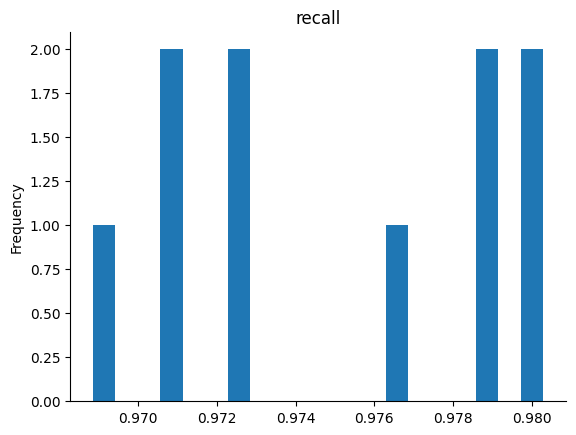

In [26]:
from matplotlib import pyplot as plt
results['recall'].plot(kind='hist', bins=20, title='recall')
plt.gca().spines[['top', 'right',]].set_visible(False)